# Мешок слов и классификация текстов

Одна из базовых задач машинного обучения - это классификация (отнесение объекта к одному из заранее заданных классов). Классификация очень хорошо подход для задач NLP, так как многие практические задачи можно свести к классификации (определение спама, определение тональности, определение намерения пользователя и т.п.).

Есть очень много алгоритмов МО, которые применимы к NLP (есть простые и быстрые, а есть сложные и медленные). За одно занятие все не разберешь, поэтому сегодня поговорим про самые простые алгоритмы, которые удобно использовать в качестве базовой (baseline) модели. Более сложные алгоритмы (например, lstm или transforemer) будут скорее всего работать лучше, НО помимо качества в практических задачах часто есть много других требований и ограничений (скорость, память, интерпретируемость и тп). 

В любой задаче классификации текстов - сначала попробуйте простые алгоритмы!

Попробуем это сделать на предсказании токсичности текста.

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
data = pd.read_csv('data/labeled.csv')

In [3]:
data.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


В определении тональности токсичных текстов обычно значительно меньше. Дисбаланс классов может сильно влиять на качество модели, но сделать с ним практически ничего нельзя (можно пробовать выкинуть часть мажорного класса) 

In [4]:
data.toxic.value_counts(normalize=True)

0.0    0.66514
1.0    0.33486
Name: toxic, dtype: float64

Для того, чтобы понять качество обученной модели нам нужно разделить данные на обучающую и тестовую выборку.

In [5]:
train, test = train_test_split(data, test_size=0.1, shuffle=True)

In [6]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

### Векторизация текста

Машинное обучение на уровне вычислений - умножение векторов и матриц. Чтобы применить машинное к тексту - его нужно превратить в вектор. Векторизация - одна из ключевых проблем современного NLP. Прорывы последних лет - это в основном новые способы получать хорошие вектора для разных видов текста (на разных языках, коротких, длинных, диалоговых и тп.) 

**До крутых векторизаций мы дойдем к концу курса, а пока нужно разобраться с простыми способами.**

Базовый способ векторизовать текст описывается метафорой "мешок слов" (bag-of-words). Чтобы векторизовать некоторый набор документов (=текстов) мешком слов нужно: а) составить словарь всех уникальных слов, встречаемых в этих документах б) посчитать частотность каждого слова в каждом из документов в) зафиксировать порядок слов в словаре и составить для каждого документа вектор размерности N (N - размер словаря), где по индексу i стоит частота слова w_i в этом документе. 

Вот картинка для наглядности:

In [7]:
Image(url="https://i.ibb.co/r5Nc2HC/abs-bow.jpg",
     width=500, height=500)

Почему это называется мешок слов? Потому что при такой векторизации теряется порядок слов в документе (порядок слов в векторах один и тот же для всех векторов). Вместо последовательного текста получается неупорядоченный мешок отдельных слов.

На картинке выше частотность записана в абсолютных значениях. Лучше использовать относительную частоту (наверное это универсальное правило для всех нлп задач вообще).

In [8]:
Image(url="https://i.ibb.co/47bRcVy/bow-normalized.jpg",
     width=500, height=500)

CountVectorizer в sklearn векторизует как раз таким образом

In [9]:
vectorizer = CountVectorizer()
# в векторайзер нужно засовывать тексты строками (токенизация там встроена)
X = vectorizer.fit_transform(train.comment)

Еще вместо нормазиванных частот можно использовать tf-idf (term frequency - inverse document frequency). 

Кратко про tfidf на картинке

In [10]:
Image(url="https://miro.medium.com/max/3604/1*qQgnyPLDIkUmeZKN2_ZWbQ.png",
     width=500, height=500)

Tfidf позвозволяет оштрафовать слова, которые встречаются в большом количестве документов (грубо говоря это стоп-слова, но специфичные дла корпуса) и поднять важность слов, которые встречаются часто в небольшом количестве документов. А в вектор таким образом добавляется информация обо всем корпусе. Обычно для модели это оказывается полезно.

In [11]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train.comment)

In [12]:
X.shape
# первая размерность - количество документов
# вторая размерность - количесто слов в словаре

(12970, 63744)

Слов получается в 5 раз больше, чем документов. Некоторые алгоритмы не смогут так обучиться (нужно чтобы признаки <= документы), а те что смогут будут обучаться сильно дольше. И учитывая, что большая часть слов встретились по 1 разу, они все равно никак не помогут.

In [13]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(train.comment)

In [14]:
X.shape

(12970, 7509)

В словаре у нас 7,5 тысяч слов  и каждый документ мы описываем вектором такого размера. В этом векторе положительным будут значения, соответствующие словам, которые есть в этом тексте, а нулевыми - те значения, которые соответствуют словам, которых в тексте нет.

**Нулевых значения будет значительно больше!**
Поэтому для эффективности в sklearn такие матрицы хранятся в специальном sparse (разреженном) формате.

Просто взять и посмотреть на матрицу не получится.

In [15]:
X # 200667 из 97391730 позиций в матрице ненулевые (это меньше 1 процента)

<12970x7509 sparse matrix of type '<class 'numpy.float64'>'
	with 200667 stored elements in Compressed Sparse Row format>

Некоторые алгоритмы не умеют работать с разреженным векторами и такую матрицу можно привести в обычный dense формат (X.todense()) НО будьте острожны с большими матрицами - они будут занимать в памяти ОЧЕНЬ много места.

Между получившимеся векторами можно посчитать близость используя косинусное расстояние. Есть геометрическое объяснение косинусного расстояния, но мне кажется проще понять, что проиходит, если посмотреть на формулу.

Формула вот такая:


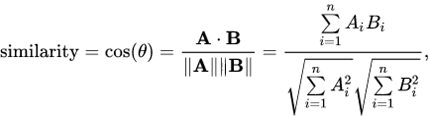

In [180]:
Image(url="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAa0AAAB1CAMAAADKkk7zAAAAaVBMVEX////l5eXBwcErKysAAAD6+vqoqKg5OTnz8/OEhIS+vr7u7u739/fa2trT09OhoaFPT0+Ojo7KyspaWlpkZGS4uLhqamqxsbGZmZlvb29+fn4hISEQEBAmJiZ0dHQ+Pj5HR0cYGBgyMjL2v28PAAARmUlEQVR4nO1dCXucKhQFBTcUxA3cl///Ix/gjEvGNpklyWvi+dqkmZmg9cjl3IUrACdOnDhx4sRLEJo/J/4JRDJKWI6/+zROfASkKl0Z9Ml3n8eJj4A4ZQaIa333eZz4EEgvQDJ6pyn8JxA1EPtpFH33eZz4ALAzAC+rOPzuEznxAeAgByDxz3XrxIkTvxMEQhhdADVOXfg/RpCmlX9BVaZx8VYXErr7MfTCUP/9ujM8sYJOqKQXWDIdkb9/Pyz77Y84kdyXDuMyOSfhNyAfx40WTAZ3z0KOpu1sw0mGms7hXTs6J11fD1yhfsMHTIPtu7BA7t4Ls8ZCf8ubfm8iT3wJSIwKb/0xEds3nWGw96xIxPW3YDzZ+hbQtmF/eisT8bijD5SNmXwl8k+l8S1wmvo4WYK5D7I9W9EwJR6kfOjOMNX3AHcoPrz2QUywj+T2pXycJJNpy0+N8V0gA6rI7cuwVBbSR5X+t8Xn1yTKckc4aa/tocUOfuvEZyOpx4NsiVMzwdKZLZHOk6lsjGHMGz0b2WkOvwVxdjtLoriqOj9FRrFfJEXUT0YKBrVLAT6t4bdAZAeTRBqaLBQD4Ak56/WgmeeYj0pMEn6K+G+AlR5cdmcw081CgyKpyuaIFDOaw5P1lADBJv/21058MpIs3/xkOMJWNWkvDLKyaStBnDjXL/o2cruyKlxNLxWx+MOIJz4NJN1q9MQwhy0upXoZSs4YzwEfwhDgoOqqMssqmZvgB09PkfHVwNmWLDoc5fth0R2U2KSc/tqFixwrrJAYfFqYB/Nq81Me20enEZWpcyMaSZo6v3VyifQwBRHyfojjwXXTrAoO3n8afHKsYAbjWY2qow+FiTjwx5JfSxYeUH8UGMB5ZyM0+FXnIvsTwj3J1A69wdDbNWqms7z6A0hG1Pxh7pTIxMipi+rX15BFQjhXCIXgjKx/ACVCuzTTClKgRl6+8y8+qxOHIG3WoPqwsnlhK0Xj6d/8L8BqGiMkj8yQZsuHMKrGkR9OvqeAq+0dgCNxTt93gYcsFM2xzlBsITdN4wbdVI+94sjddi0kvJhef4yfhkTph9BGzRoBgv71ntdzq1T62onr9BME2246Y8rb1x/ip6EcpRA9Qtli6nI0Xa6jZsvUTQiE0lcrtoTJvVcg6xcf4ecBtqNyeCaExiWSY/K2BleVAShC7YttYciZHQLJZzhqcp1svQs5OollWUpn8GXyLEvYwlaCkP3i4IFn8SEE1zp4fSv8BrbCzT1P7q9V6DPzLVc644CO2Tv2NJndoyf4J3iTWh7pzBX9P7CF6adHs6B/CUPQHIOI53//9BtEQ4saPWm6VnnIdr9X6aFvN8pC2m3doPb1mxcDGzqhuED/J9hXsOVxefsizn0CrGk8uiMJZy9bsT0/M2NFZVeqYznZXXmE0MotK1cD0EBZw/wt1ZF6dw67WvT17pZwfQq8GcRTV2VAX7BFEjb17SWC8egAT+rCgtvTHE31t3iFJrZcc2yYxV7eK8vSZf9MeQkJdroFR9T6fFMEvKq6vfFC1qlzge4RW1FnAged8/yxSVfqb5i3CYhiNbny/lNyGz8I4ZGVwPpF2B+xBTxNVpS+IPKW2MZ20DbTofRUR/SK50f9mQikk1AcJQkEUH0JBYMAm+SZelHP6pktyLjOnWH9mSjx1JRXqwApRk4j/VqivlL15S8H8gIpjZGAjmPMR+hwJ4m0jNIqEHNdF5mb6rvKff0K8xMQplxIm3tdbSehdO2u5IUrO99vfUD8VutTw1Zgp3k3CLWK2W3aTWVSjHEU8hq5Q0XEUNuVx9rmqLz4ChqnTjclSqTFjpP6ykuJufBtBkhm6/cjV+s6ZvYWOtPZzOAIeQPVuuErk9ZYgDhoikI6tsyL+ilUnnrjXNhiKFNSWQmLkKM4H1KI41aJoapmEAKPTq26vJN/IStI4xUX8RLGamhdwe/UCcbJJDF3FWOZBDA13pLVjGkajyZIJNyrgRWbke6TivcAs2E5ylD9f9PvQZMFEEYAd3o/ZqQ4AbC29dKhk0V5c51bJNAOjf6MUC6mdmALxRaQ7awH/CYH0RLiDuEGF+PoNEo+EOGRelA/ebFNeNNZUPn/0WBWKQd1hFita5Rme/UnvIOhAEm0Vn8ewUI/2RxlqcaB1msO8zQW2enFqBkzAsJSM0H1vj1YT1q8a7bEwhagVe+OOlPuXPZBG7Z4Pbs3SZ2B6k9bzjRwZar1le9r/AGvaCjsUVN3an65mi3s63lszUXjef3XLBGNW/sVqMu/HQWI/jWHeRqbcFreTWq2XNjSATXDFin2bAmdbaj0Z1gt92xF2v6lo5Utshtu7/3wytbM68JWotRGNjZcWULNUFjpA/pz5cTKFtzcYsl1VcTwRViWWbiecLD40OH7A3wNltO0ND3FBHA5JvpSLmylO7aiwVZvF7UMsFOzC1vRzFanJw1ren+x95T7Ky7T2FhCJTPhqNN1pK8hFwDTOFNsGQ/BryGg7ny359N13bKqdST+aS3KwnxzGPa/XLcwVQZaKCGGearmkq4YShBXtmq0jSWk+hIzXSs0KGs1UUD7tpKENbMlzJQvq0hyQKWnA+nRGvLB3gaXVYAMtpIojGOmb4tk5F7WKxegVNO6M+lW0VLcXYKyrE3+MtQnINwc5X9ZtIT56GOQt7FfDQmJ2yZ2pIvq0hpQU7CiaQbObdRy6jZNkTj1wLvUbjlrUZtZgJYjmnItE4u56LIb3rnzo9juulKtkNItK9cHXlmnfpZGelOanuqwjLP4MkbVP+lv/TORq49C93kItRgKAqLTFIRgXYTsYf0l9HQxcmgqkvXPxrLDkCrxbT6p7nnzTb2ceObi+O+GoDxqPqtWHcvSI0Qwys2qRntj90iQXG5rGL+f2dAaNVjduw09kCrvXr8T5rpI9uiXo0Tpykc3keI78IIhLmNgWL4oYpCoxSl73J/VlngHZ3o/Tpiq461lFliuDaMDP8QmDk5iDIiSK2EgRG5SGtZcDu8xBqj/0CoYOYw5HwcTB1sm7xviEvhRovxFe5Q5cuQzxV803vm9XvGBMOGerbxeawkDH2OTLyPaT1Q3AhzGRvkpjcJoHHjC5KNslZPbux/HlN4ehdV3DKDQC30jhtmrGpjTePCfElIi3d438mAP7w00UytbKULs+p/ZsQW13sTURjYOsceR8ee8x9lSVz+8C7dDSP7IEPCwVvIhPLvdGTsbbzj50HXcsRW1CA3X++WWLQAnZHQnbU2PrGfYelreE/+xtMX/SDjhu2+cHVuVzuZfPYgNW6Fh7IVsJc8vHvQ3bg3fsoXtMlv3LKxsDZb6q19SbNnalXJQo93vx9mS8mlhJn5jf6ctW05jJSO69hfZsQUb/ZJia6yqSjmRvjYoj7NV3lfgcwR5uB3vh2PLVjp4YFj2LPyBLc65P4ypbrn5OFvx88Ev/vIquX8AG7YipcsJX2oJj9ky61Y0oDZ/CVshhATCB8yi519TFTpoTB4Z4h/Ehq2qyaqqXHTGRmXAN2yFSsJnT7BFi6skZFlfVfEDRXrRtXRSuS1xxoffsYqtbOEplgrZdc/CThPu2cKKrfgJthx+lYS+0yageuBSB9cEOwj4IIH/O1pmrGyJ0dyttL7ojI0lTC5sRUoTms/EpiT+Ybb8JZ5AeBqCmN3vBMl12ZLK1U5/h+a4spXzqdFVj4lauFCmU2A3bHlO1aBGq4weNTpO8jBbG5ERc+WT/73I6xAbkVFkAPbsgbL/fw9Xtvxpcm2BgTO4vTvpcPDGEnqGLZjq4N5k23ZfmJXmYbbWrBBpLMBcIe42hXyJ2oR9BcTg57/BFO7jhFvsI0/NwSceZQuufe2ilABa+nfPC8jXegh1kpH/XID1X8FH2Tra8vEoW9b97NwM8T+uf/tE6IxJ/Be2tBPc6WzJwScezZj4zh2GLzx0pdhdvjH8KdRmyfz3FhbHmFuaLa53RBx8wmQjH6jJmedyqBPrlxKO45yIBhHcPzi9WRJibz/EH/qJJbJyfob3rBfn4wU6UkyZgkmd5T/M9IdUiUXrfqtmRAbhlWQzJPe76oYTDM2d0tHMvT0/qUWGEqnSWYaoqio/pDzPLFmL/1Gm5J9CaBLBpEfT5VrzMusblL65nlTXLOvSkqi+acQKfR1vIQWq+TyErLKh3jwIJRRMmHcSDKqBgP640fyJd3FRCFY7biLxYnjTryjMdBGmJ4Ty12/YSiqT3KI92qZf03EpQSLFiJpJeSWTTxLmgWH4De7YZ4BfgvwS2RvrF6X7Pnr5pYOA+nx/szSKah4ir7ctp8Jis9VRIhP2TQ2fif2C3Yy/E8XVVSpQvLnjKd+uOjDuL53a8vS2DExeK+85cjcpZMhWXlNkbgUfZUQ5eGfXqEexVGbBnSEDu0dFskLOfR6oYuAmp790dSUZ2tYKrY1k8TQ/XS1WU4w4OUh+RYz+9cBrHZ1VN39IIicxdHRSBlhxFfC36xbhyz4cvXQdyT3LdFAgvC68sMiE+Ej914lbJJuHjvD98wUXeB0HFkp10tEe3PhtEWu06c4gmvqIcY5SpRTTSa1Xge7/ys+59RAcud7mYbZpALaBVSjDiFzd+SYI5kLyLfJqc+19dKtC9LLV8crvUhYCqpt83B/lP6HRbadC5KIDv5UMKXP8OZd2BLktQoYpqm6GCKe5FVWKzoeAPoVhF7SQR11f2VQURYoOW8KbX9ptxszb29yzVc8LlY+6c8F6APR61XbF+l518MCYKE4IJMlck09WVQ6vPPOdIJcH8Xh+eRJeaiq4nFfVvv8WLE/Epbs+r1V3u/rjzjDouYYturQgIFeSol0LKHbUODZF5rfYvKaVD5QS/GpwdBHdawWNfvX2eVuEp9p6YeqPqNRWcvmENc4N+UC+tW7iNjsXOn6DOsl51s7JIHiSdRfg4hZVm2VfbDf6hLO5gmWaKtOGgzLLMgkidiWDdPoJXBoyW3/L2kU6EkOtx4ssK8uy6MxDT4hzBuDvA4+bi3+6SX0mu2nBZmWHiefp3aKeecYN4dW1O5YV15de2htJGGXbAKCoZva9+Qk5lxnIpf1p++J/JAhn9sUrGhaRQYutlmf2kZNLHD+7/ovHl03vchEZsNs9sms6DAcK4Z5s3QMPkn68NE+8Xjkv89XtD4nes52IYqwPpTa97sb1Ilg0ZiKtZbqeX0aeHgJDQoVvj8c7d+PzQYX3IkZzw5VrcVKYotpuFQa7tccGoeJwcZE9WeYcn4PA1jV0hTlqJjWC7U6tXashjjdDQJsebFs+8TeUsyhcG9M6jMkrGGPO4ZUOfZstMkKYOC8Q1xoRnOyH0IniA1j2XWU7J4CeGCbicJCs+iuoXJWIhWJNB7uzRyZh4mfU0HwhxGh8q/je/aeb6UJtIxfkvcvQqd/vRmLr5AhZRAaI3iQIrXeFWxTrZmPrk1UAfNNaJTlLZV6FvqG7GttdaxAcdPa7rVhIafplrfWmV/9qhlXVZ/XFq5BqUbjZHr4voIUCvb8X2fSfFWsA3ot2pRyiOWjGf+IhdFoUro2R8jeZkvBPSf8Nci0K2RJ3St5IPdKebL0KrKnCNbkl8t4C1uWhQLo6m3yALQsN4bqZP2eZD5LLCLrUF9YnW69CMKYQpFdJKJKaAnJ9KFD4MbaiaYq8pYKGirhahyD6gVQnW68Cbe2IlkvcScZ7J+gjbMF0tKJqccCcYe8OnGy9ED2izioyXCcIxcWKfdQSeiVykrW/YJlFEfU3lrD9WwPpE3chRbRcpEVkC58sfc8xiPLmA42blCgMFpFBikzQpZOzB0g+FtEZtXgRKsTWCppQyq2vhPNcivfLk5QoDNadZLm/4zcRzBGnf/wisKbcLDThPgzhhfjwgT17WKPNVw8Ykx29oYfxJ3Z4/mWw2vq2DOM+0AF9xtN7T9wCTujg4WT3DVGgc9vcF2FA8klDFfooe/9TJ16BDD39rD2Gzp1YXwR/erq5aj6dYfYvAsuerj2yjrtFnHg94M3WnvuHeKDhw4l/Gv8BnCgeUlxeEn4AAAAASUVORK5CYII=",
     width=500, height=500)


В числителе здесь скалярное произдведение - это такая операция с векторами, когда числа, стоящие в двух векторах напротив друг друга перемножаются, а результат складывается. 

В знаменателе тут произведение длин векторов, а длина вектора считается как произведение корней из суммы квадратов значений в первом и втором векторах.

Вот пошаговая визуализация расчета близости для двух векторов с абсолютными частотностями.

In [184]:
Image(url="https://i.ibb.co/pb8ZCJT/tg-image-911960310.jpg",
     width=700, height=700)

Выглядит наверное сложно, но важно понять, что тут происходит. 

Вверху (скалярное произведение) по сути происходит поиск общих слов в первом и втором векторе (=тексте). Если слово есть в одном тексте, а в другом нет - то результат произведения будет нулевой. Если мы будет использовать не частотности, а какую-то метрику с возможным отрицательным значением, то скалярное произведение будет штрафовать пары значений с разными знаками (будет получаться отрицательное число и сумма будет уменьшаться). **Чем больше значение скалярного произведения, тем больше будет итоговая близость.**

Внизу - просто нормализация. Результат скалярного произведения может быть любым (отрицательным, положительным, большим, маленьким), но хотелось бы, чтобы метрика была в интервале от -1 до 1. Почему тут не просто сумма? Потому что значения могут быть отрицательными и может получиться ноль. Для обхода проблемы с нулями часто используется корень из квадрата 
(почему не абсолютное значение - как я понимаю сложный математический вопрос, часто пишут что абсолютное значение сложнее математически, а квадрат проще)

Попробуем посчитать косинусное расстояние между настоящими текстами.

In [26]:
train.loc[1, 'comment']

'А их не покажут. Они так быстро двигаются, что даже после аварии с собой номера уносят со скоростью Флэша.\n'

В sklearn есть косинусное расстояние и косинусная близость. Близость это просто единица минус расстояние, то есть расстояние между близкими векторами должно быть маленькое (0 если совпадают 1 - если вообще не совпадают), а близость наоборот (1 если совпадают 0 если не совпадают совсем).

Расстояние удобнее использовать, когда нужно отсортировать по близости, т.к в numpy по умолчанию сортируется по возрастанию.

In [27]:
# функция предназначена для расчета близости между массивами векторов
# и возвращает она тоже массив где каждая строчка это объект и первого массива, 
# а каждая колонка это близость до объекта во втором массиве

# в нашем случае в первом массиве у нас только 1 вектор
# поэтому мы можем взять первую строчку из получившегося массива
# метод .argsort вернет список индексов по возрастанию 
# возьмем первые три индекса и посмотрим что там за тексты
cosine_distances(X[1], X).argsort()[0,:3]

array([    1, 12805,  5972])

In [28]:
# первым нашелся этот же вектор
# а дальше уже не настолько близкие но все равно есть сходство
train.loc[[    1, 12805,  5972], 'comment'].values

array(['А их не покажут. Они так быстро двигаются, что даже после аварии с собой номера уносят со скоростью Флэша.\n',
       'Я вот тоже не понял. Допустим. Ну летит Старфайтер со скоростью 2 Маха. Стреляет снарядами со скоростью 1 Мах. Скорость снаряда - 1 Мах свой плюс 2 Маха самолета, итого 3 Маха (про Эйнштейна не надо, пренебрежем релятивистскими эффектами). Как самолет со скоростью 2 Маха догонит снаряд со скоростью 3 Маха? Да, снаряд не имеет своего двигателя и будет тормозиться о воздух, но он: 1) успеет отлететь на приличное расстояние от самолета, 2) летит по другой траектории, чем самолет - у самолета, условно, прямая линия, у снаряда - баллистическая. Ну разве летчик будет пытаться повторять траекторию снаряда в течение того времени, пока не догонит снаряд? В общем, вопросов у меня больше, чем ответов.\n',
       'тоже поначалу показалось. Еще удивился, как они синхронно двигаются - -\n'],
      dtype=object)

Мы векторизовали обучающую выборку, осталось векторизовать тестовую

Векторайзеры в sklearn имеют три основных метода **fit**, **transform** и **fit_transform**. 

**fit** - собирает словарь и статистики по текстам,   
**transform** - преобразует тексты в векторы, на основе уже собранного словаря.  
**fit_transform** - делает сразу и первое и второе (быстре чем 1 и 2 по очереди).

Для теста нам нужно векторизовать тексты тем же словарем, для этого вызовем метод .transform

In [32]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(train.comment)
X_test = vectorizer.transform(test.comment) 

# Анализ тональности 

Интуитивно кажется, что bag-of-words сильно упрощает - порядок слов ведь очень важен для текста! Однако на практике BOW работает необъяснимо хорошо. Начать решать практически любую классификационную нлп задачу лучше всего с мешка слов и просто алгоритма классификации. Это хорошее базовое решение, с которым удобно сравнивать более сложные решения и к тому же есть шанс, что уже такого базового решения будет достаточно для практического применения.

Попробуем такой подход в задаче определения тональности. Нужно предсказать является ли пост токсичным или нет.



Повторим еще раз векторизацию и достанем отдельно целевую переменную.

In [33]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.4)
X = vectorizer.fit_transform(train.comment)
X_test = vectorizer.transform(test.comment) 

In [34]:
y = train.toxic.values
y_test = test.toxic.values

In [35]:
# ! Называть матрицу с признаками X, а вектор с целевой переменной y - стандартная практика. 
# ! Если вы сделаете наоборот, то сильно запутаете меня в домашке 

Теперь попробуем обучить модель. Рассмотрим три простых алгоритма - метод ближайших соседей, логистическая регрессия, дерево решений и наивный байес.

Кратко идея этих алгоритмов:

1) **KNN** - это предсказания класса текста по близости к другим текстам, для которых известен класс. Выше мы считали близость между текстами косинусным расстоянием - в KNN делается то же самое, только рассматривается топ-K ближайших текстов. В KNN таким образом нет никакого обучения - просто запоминание тестовой выборки и сравнение с ней при предсказании.


2) **Логрег** - это по сути взвешенная сумма всех значения вектора. То есть мы берем вектор текста (с частотностями или с тфидф) и каждое число в нем домножаем на еще какой-то свой коэффициент, а затем складываем все и нормализуем. Если получившееся значение больше 0,5, то считаем, что этот текст "токсичный", а если нет, то "нейтральный". Коэффициенты подбираются на обучающих данных (это и есть обучение). Можно сказать, что в итоге для каждого слова находится показатель токсичности. Если в тексте будет много слов с высоким показателем токсичности, то весь текст будет отнесен к токсичному классу. Однако показатель токсичности не равно вероятность токсичности - он может быть равен любому числу (например, 0.282, -4815162342, 666.13) Интерпретировать значение показателя можно только по отношению к другим значениям. 

3) **Дерево решений** - это просто много вложенных if else. В процессе обучения подбирается такая серия условий типа "тфидф этого слова больше 1.23", чтобы в итоге получалось предсказать правильный класс текста. 

4) **Наивный байес** -  это тоже взвешенная сумма значений вектора, но коэффициенты здесь рассчитываются по-другому. В логреге взвешенная сумма - это одна цельная функция и параметры подбираются так, чтобы после умножения и суммы получались правильные предсказания. А в наивном байесе каждый коэффициент расчитывается отдельно без учета того, что вообще получится, если расчитать взвешенную сумму. Можно сказать, что в наивном байесе ничего и не обучается, а просто считаются статистики, из которых выводится вероятность каждого параметра (=слова) для конкретного класса. Вероятность расчитывается по формуле - количество раз, которое слово W встретилось в текстах данного класса разделить на общее количество слов, которые встретились в текстах данного класса. При предсказании взвешенная сумма (каждое значение в векторе умножается на вероятность этого слова) домножается на вероятность класса в целом. Она считается просто как количество примеров этого класса поделить на общее количество примеров.   
   *НБ логично использовать с абсолютными значениями частотностей, но он будет работать и с тфидф значениями. В этом случае, "количество раз, которое слово W встретилось в текстах данного класса" - это не количество раз, а сумма всех тфидф коэффициентов этого слова в текстах данного класса.*

У алгоритмов в sklearn стандартный интерфейс - есть функции fit, predict и predict_proba

In [36]:
clf = LogisticRegression(C=0.01, class_weight='balanced')

In [37]:
# fit обучает модель
clf.fit(X, y)

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [38]:
clf.classes_

array([0., 1.])

In [39]:
# предикт предсказывает классы
preds = clf.predict(X_test)

In [40]:
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.85      0.84      0.85       948
        1.0       0.70      0.71      0.71       494

avg / total       0.80      0.80      0.80      1442



In [41]:
# predict_proba возвращает вероятности классов
# это полезно когда нужно подобрать порог например
probas = clf.predict_proba(X_test)

In [42]:
# в левой колонке вероятность 0 (нетокстичности)
# в правой - вероятность 1 (токсичности)
probas

array([[0.51740106, 0.48259894],
       [0.4963216 , 0.5036784 ],
       [0.46812591, 0.53187409],
       ...,
       [0.50655666, 0.49344334],
       [0.5004294 , 0.4995706 ],
       [0.50767687, 0.49232313]])

In [43]:
# возьмем вторую колонку
# проверим что она больше 0,85
# заменим True и False на 0 и 1 чтобы получить предсказания
preds = (probas[:,1]>0.85).astype(int)

In [44]:
# точность по токсичному классу сильно выросла но при этом упала полнота
print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.66      1.00      0.79       948
        1.0       0.00      0.00      0.00       494

avg / total       0.43      0.66      0.52      1442



/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Попробуем другой классификатор

In [45]:
clf = MultinomialNB(alpha=1.)
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.81      0.98      0.89       948
        1.0       0.94      0.57      0.71       494

avg / total       0.86      0.84      0.83      1442



In [46]:
clf = DecisionTreeClassifier(max_depth=8, class_weight='balanced')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.80      0.52      0.63       948
        1.0       0.45      0.76      0.56       494

avg / total       0.68      0.60      0.61      1442



In [50]:
clf = KNeighborsClassifier(n_neighbors=10, metric='cosine')
clf.fit(X, y)
preds = clf.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

        0.0       0.83      0.84      0.84       948
        1.0       0.69      0.67      0.68       494

avg / total       0.78      0.78      0.78      1442



У каждого из классификаторов есть свои параметры, которые нужно подбирать под задачу и под параметры векторизации. Значения параметров можно просто перебрать, но их может быть настолько много, что сделать это не получится, поэтому подбирать часто приходится вручную по интуиции. В документации есть достаточно подробное описание параметров, но понимать, какие значение нужно пробовать, вам поможет только практика!